In [169]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import linear_model

%matplotlib inline

In [170]:
df_bid_ask = pd.read_csv('bid_ask.csv', index_col='timestamp', parse_dates=['timestamp'])
df_bid_ask
# display(df_bid_ask)


,bid,ask
timestamp,,
2013-09-02 08:30:00,2994.5,2995.5
2013-09-02 08:31:00,2997.0,2998.0
2013-09-02 08:32:00,2996.5,2998.0
2013-09-02 08:33:00,2996.0,2998.0
2013-09-02 08:34:00,2997.0,2998.5
...,...,...
2013-09-13 15:56:00,3118.5,3119.0
2013-09-13 15:57:00,3119.0,3119.5
2013-09-13 15:58:00,3122.0,3122.5


In [171]:
df_transaction = pd.read_csv('transaction.csv', index_col='timestamp', parse_dates=['timestamp'])
display(df_transaction)


,transaction
timestamp,
2013-09-02 08:32:00,2998.0
2013-09-02 08:33:00,2998.0
2013-09-02 08:34:00,2998.5
2013-09-02 08:35:00,2999.0
2013-09-02 08:38:00,3020.0
...,...
2013-09-13 15:54:00,3119.0
2013-09-13 15:55:00,3118.5
2013-09-13 15:56:00,3118.5


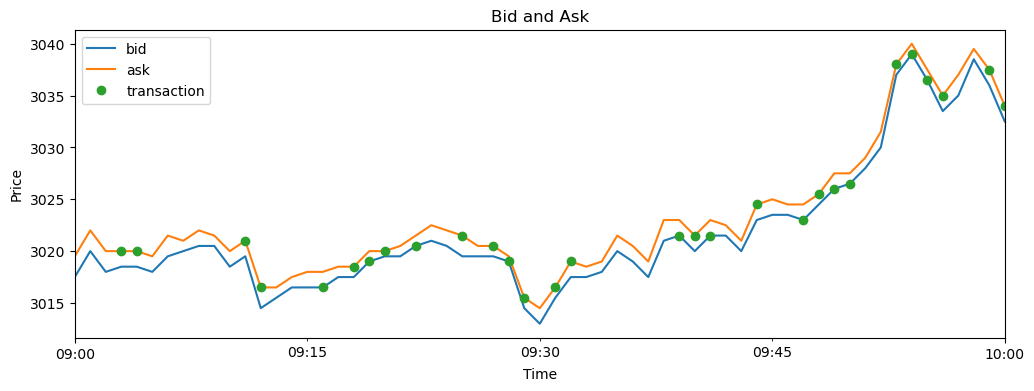

In [172]:
plt.figure(figsize=(12, 4))
df_bid_ask['bid']['2013-09-02 9:00':'2013-09-02 10:00'].plot(label='bid')
df_bid_ask['ask']['2013-09-02 9:00':'2013-09-02 10:00'].plot(label='ask')
df_transaction['transaction']['2013-09-02 9:00':'2013-09-02 10:00'].plot(label='transaction', style='o')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Bid and Ask')
plt.legend(loc='upper left')
plt.show()

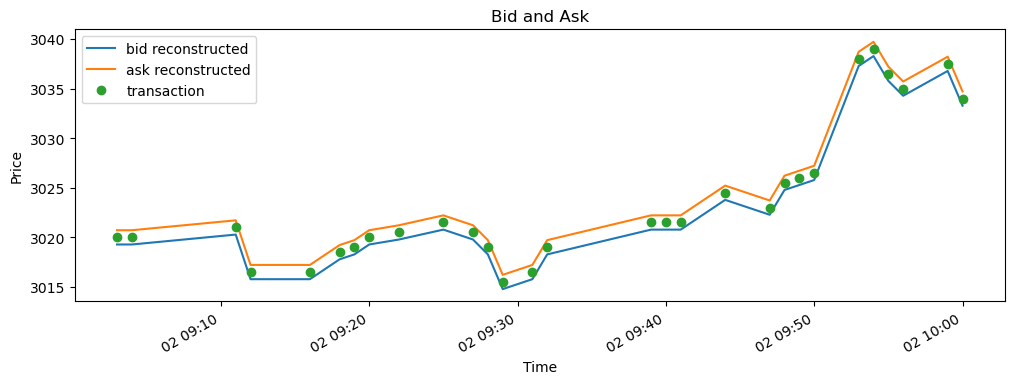

In [173]:
selection = df_transaction['2013-09-02 9:00':'2013-09-02 10:00'].index.values
df_bid_ask_reconstructed = pd.DataFrame(np.zeros((len(selection), 2)), index=selection, columns=['bid', 'ask'])
df_bid_ask_reconstructed['bid'] = df_transaction.loc[selection]['transaction'] - 0.1 * df_transaction.loc[selection]['transaction'].std()
df_bid_ask_reconstructed['ask'] = df_transaction.loc[selection]['transaction'] + 0.1 * df_transaction.loc[selection]['transaction'].std()

plt.figure(figsize=(12, 4))
df_bid_ask_reconstructed['bid'].plot(label='bid reconstructed')
df_bid_ask_reconstructed['ask'].plot(label='ask reconstructed')
# df_bid_ask['bid'].loc[selection].plot(label='bid original', color='#808080')
# df_bid_ask['ask'].loc[selection].plot(label='ask original', color='#808080')
df_transaction['transaction'].loc[selection].plot(label='transaction', style='o')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Bid and Ask')
plt.legend(loc='upper left')
plt.show()

## --------------

In [96]:
df_transaction_r = df_transaction['2013-09-03 13:00':'2013-09-03 16:00']
df_bid_ask_r = df_bid_ask['2013-09-03 13:00':'2013-09-03 16:00']
df_r = pd.merge(left=df_transaction_r, right=df_bid_ask_r, on="timestamp", how="left")

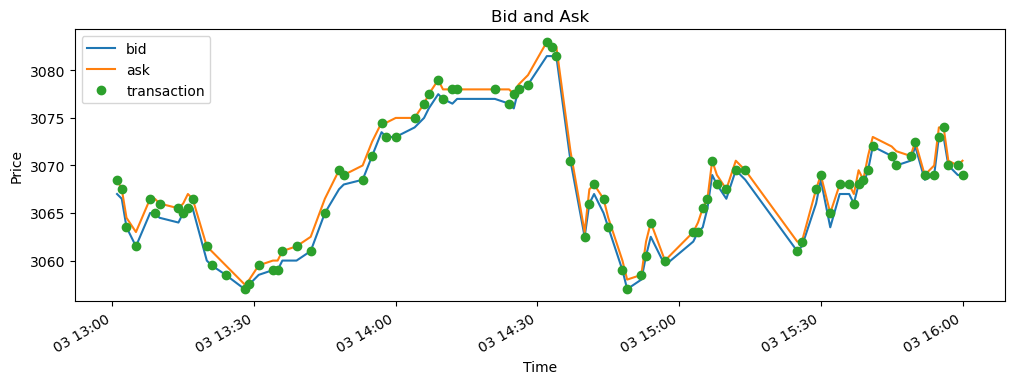

In [97]:
plt.figure(figsize=(12, 4))
df_r['bid'].plot(label='bid')
df_r['ask'].plot(label='ask')
df_r['transaction'].plot(label='transaction', style='o')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Bid and Ask')
plt.legend(loc='upper left')
plt.show()

In [189]:
df_r['ask_rate'] = df_r['ask'] / df_r['transaction']
df_r['bid_rate'] = df_r['bid'] / df_r['transaction']

In [208]:
X_train = pd.DataFrame(df_r['ask']['2013-09-03 13:00':'2013-09-03 15:00'])
y_train = pd.DataFrame(df_r['ask']['2013-09-03 13:00':'2013-09-03 15:00'])
X_test = pd.DataFrame(df_r['transaction']['2013-09-03 15:00':'2013-09-03 16:00'])
y_test = pd.DataFrame(df_r['transaction']['2013-09-03 15:00':'2013-09-03 16:00'])


In [209]:
reg = linear_model.LinearRegression()

X = X_train.shift(2).values[2:].reshape(-1, 1)
y = y_train.values[2:]

reg.fit(X, y)
y_predicted = np.zeros(len(y_test))
y_predicted = reg.predict(y_test)

/Users/clarkhu/opt/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


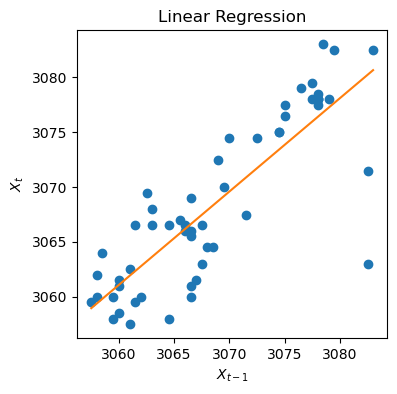

In [210]:
plt.figure(figsize=(4,4))
plt.plot(X[:, 0], y, 'o')
plt.plot([X.min(), X.max()], [reg.coef_[0] * X.min() + reg.intercept_, reg.coef_[0] * X.max() + reg.intercept_], '-')
plt.xlabel('$X_{t-1}$')
plt.ylabel('$X_t$')
plt.title('Linear Regression')
plt.show()

In [211]:
y_predicted.shape

(32, 1)

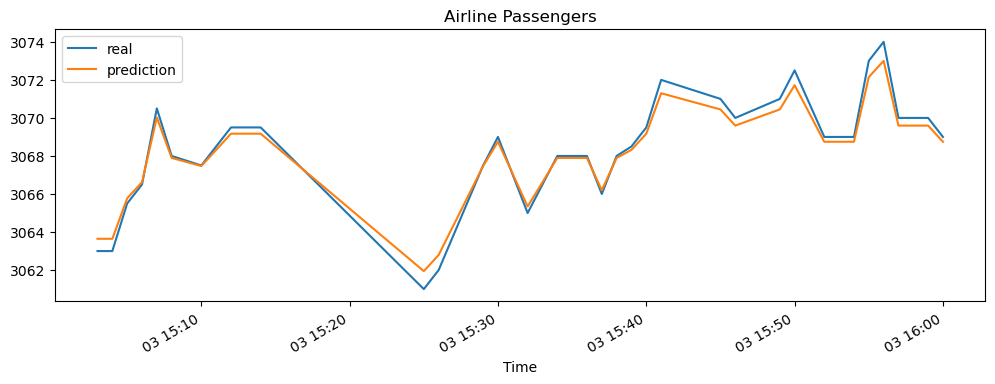

MSE: 0.2322
MAE: 0.3985
MAPE: 0.0001


In [221]:
y_test['prediction'] = y_predicted
y_test['ask_r'] = df_r['ask_rate'] * y_test['prediction']
y_test['bid_r'] = df_r['bid_rate'] * y_test['prediction']

plt.figure(figsize=(12,4))
X_test['transaction'].plot(label='real')
y_test['prediction'].plot(label='prediction')
plt.xlabel('Time')
plt.ylabel('')
plt.title('Airline Passengers')
plt.legend(loc='upper left')
plt.show()

print('MSE: %0.4f' % ((X_test['transaction'] - y_test['prediction'])**2).mean())
print('MAE: %0.4f' % (X_test['transaction'] - y_test['prediction']).abs().mean())
print('MAPE: %0.4f' % ((X_test['transaction'] - y_test['prediction']) / X_test['transaction']).abs().mean())

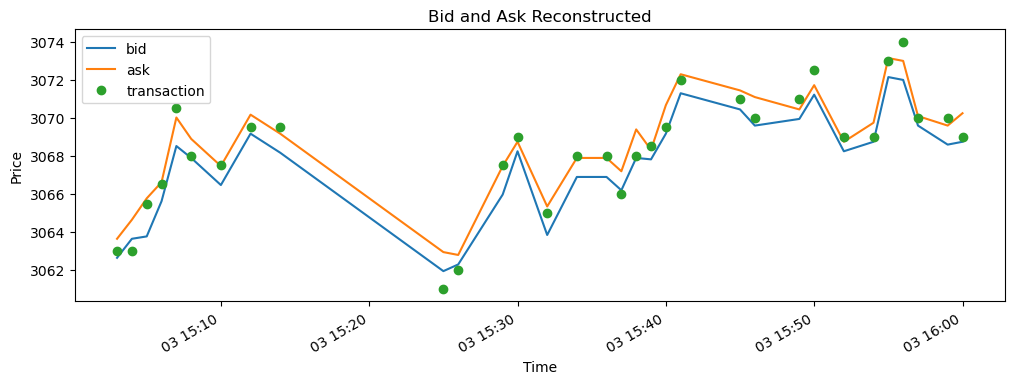

In [222]:

plt.figure(figsize=(12, 4))
y_test['bid_r'].plot(label='bid')
y_test['ask_r'].plot(label='ask')
y_test['transaction'].plot(label='transaction', style='o')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Bid and Ask Reconstructed')
plt.legend(loc='upper left')
plt.show()


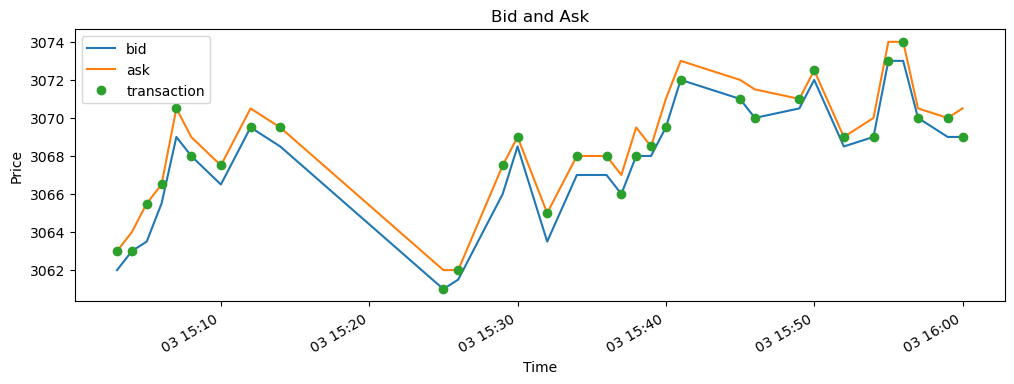

In [217]:
plt.figure(figsize=(12, 4))
df_r['bid']['2013-09-03 15:00':'2013-09-03 16:00'].plot(label='bid')
df_r['ask']['2013-09-03 15:00':'2013-09-03 16:00'].plot(label='ask')
df_r['transaction']['2013-09-03 15:00':'2013-09-03 16:00'].plot(label='transaction', style='o')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Bid and Ask')
plt.legend(loc='upper left')
plt.show()